# Grass Image Data Analysis

In [1]:
%%capture

import numpy as np
import matplotlib.pyplot as plt

import import_ipynb
import DataUtils as DU

import cache_magic # pip install ipython-cache

In [2]:
Ximg, Xlab = DU.load_data("data/grass1.hdf5")

## Raw Data

The `grass1` dataset is a synthetic dataset created from 11 photos of grass.  The images are converted to grayscale, and each point corresponds to a random 28 x 28 tile cropped from one of these source images.

Category labels correspond to the number of the source image used (1-11).

Here is a sample of the data.  Each row corresponds to a source image.

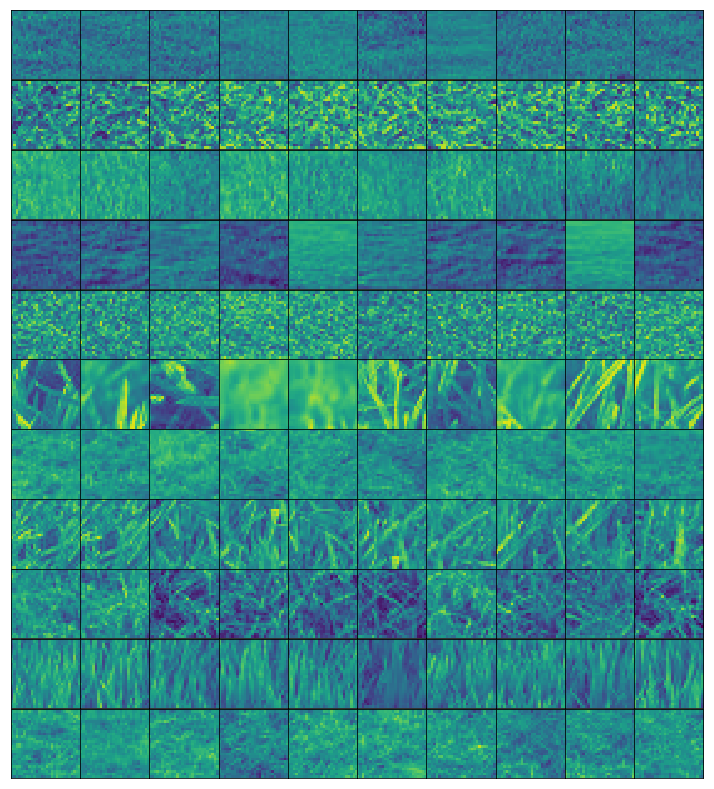

In [3]:
grouped = np.hstack([np.arange(70000)[Xlab==i][:10] for i in range(11)])
DU.show_data(Ximg[grouped], cols=10)

## Principal Components

We perform singular value decomposition of the covariance matrix to determine the principal components of the data.

### Explanation of variance

The following graph shows the relative magnitude of each principal component, and how much total variance is explained by the first $k$ principal components.


In [4]:
X, Xbar, CX = DU.normalize_image_data(Ximg)

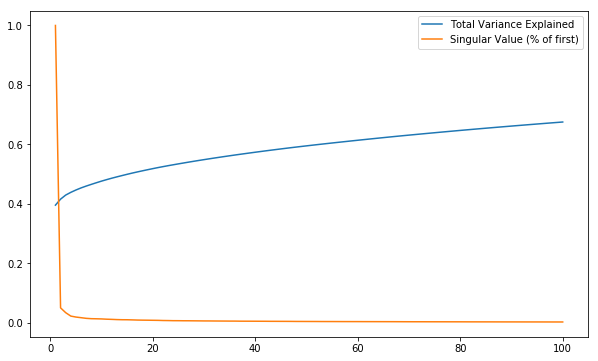

In [5]:
Xu, Xs, Xvt = np.linalg.svd(CX)
DU.graph_variance_explained(Xs)

* The first 50 principal components explain about 60% of the variance in the data.
* Additional principal components provide very modest gains in explaining more variance.

### Visualizing the Average Image

We have preprocessed our data to be zero mean across each pixel.

This is what the average image from this dataset looks like:

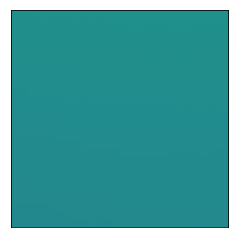

In [6]:
DU.show_img(DU.X_to_img(0, Xbar))

The average image has near-uniform intensity.

(Contrast with MNIST, where the average image looked more like a blurry digit.)

### Visualizing Principal Components

We can visualize each principal component as an image by rehaping the columns of $U$ to $28 \times 28$ and plotting them as images.

Because each PC constitutes a direction in pixel space, we view them with a diverging color scheme which makes it easy to see the positive and negative regions.

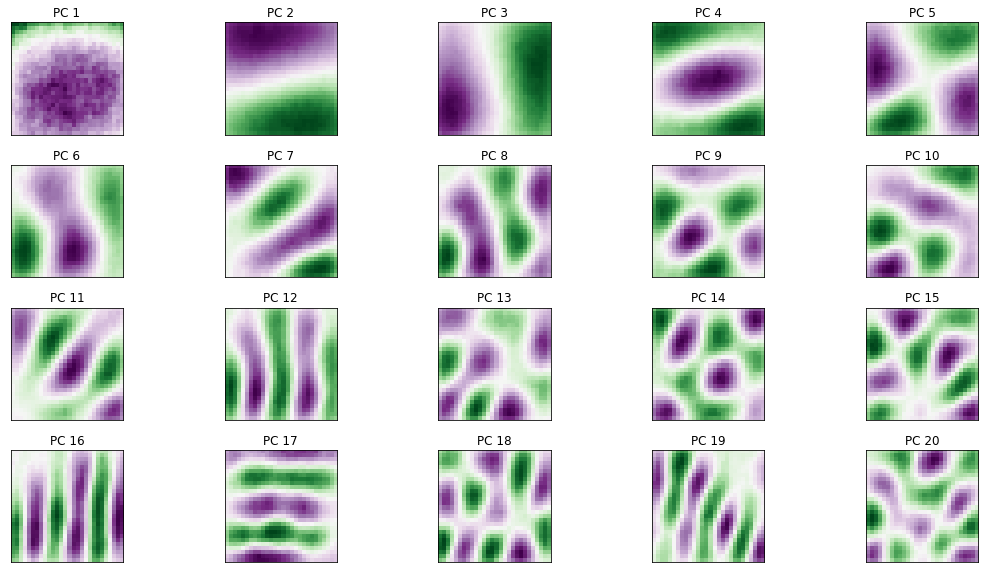

In [7]:
DU.show_pcs(Xu, 20)

The graph above shows the first 20 principal components.

* As with the MNIST data, we can see that the PCs begin simply, and increase in complexity.
* The PCs are clearly differ from the MNIST PCs (which were specialized for representing digits).
* These PCs are very general, and look suitable for representing almost any image (given enough of them).
* The patterns in these PCs resemble the basis of a 2-dimensional [Discrete Cosine Transform (DCT)](https://en.wikipedia.org/wiki/Discrete_cosine_transform), a basis often used in image compression.

### Determining the Subspace

We can attempt to visually estimate the dimension of the linear subspace for the grass data by looking at dimensionally reduced images projected back into pixel space.

Here, we examine the quality of 20 random digits as they are projected into truncated PCA coordinates.

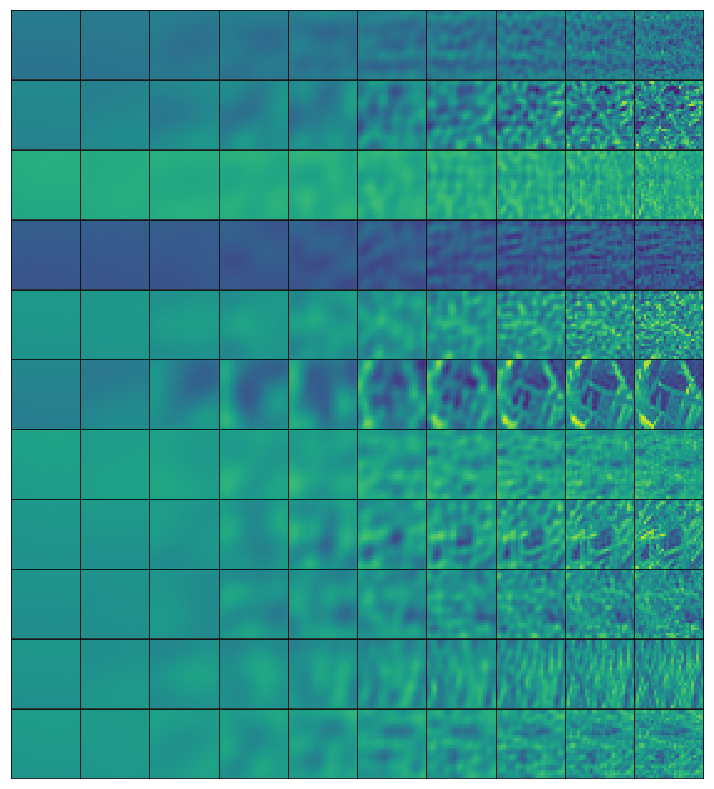

In [8]:
dims = [1, 2, 5, 10, 20, 50, 100, 200, 400, 784]

samp = X[:11]
Psamp = [(samp @ Xu[:,:k]) @ Xu.T[:k,:] for k in dims]

pcadigits = np.asarray(Psamp).transpose((1,0,2))

DU.show_data(DU.X_to_img(np.vstack(pcadigits), Xbar), cols=10)

In the image above, each row represents an original data point, and each column represents a level of PCA dimension reduction.

* Notice that the images smoothly transition from uniform intensity, to blurry, to sharp.
* It takes 100-200 principal components (or more) to reproduce an image tile with a texture that is recognizable as grass texture.


### Observations

We characterize the effects of using a limited number of components (roughly) as follows:

| Dimension | % Variance | Description                                   |
| --------- | ---------- | --------------------------------------------- |
| 1         | 10%        | average illumination of image is established  |
| 10-20     | 50-55%     | light/dark regions appear within image        |
| 100+      | 65%        | identifiable grass texture begins to resolve  |
| 400+      | > 85%      | image becomes "sharp"                         |


## Embeddings

### PCA

We can look at the relationships between the most significant prinipal components by creating a scatterplot matrix.

Here, we show a scatterplot matrix of PC 1-5, with histograms on the diagonal.

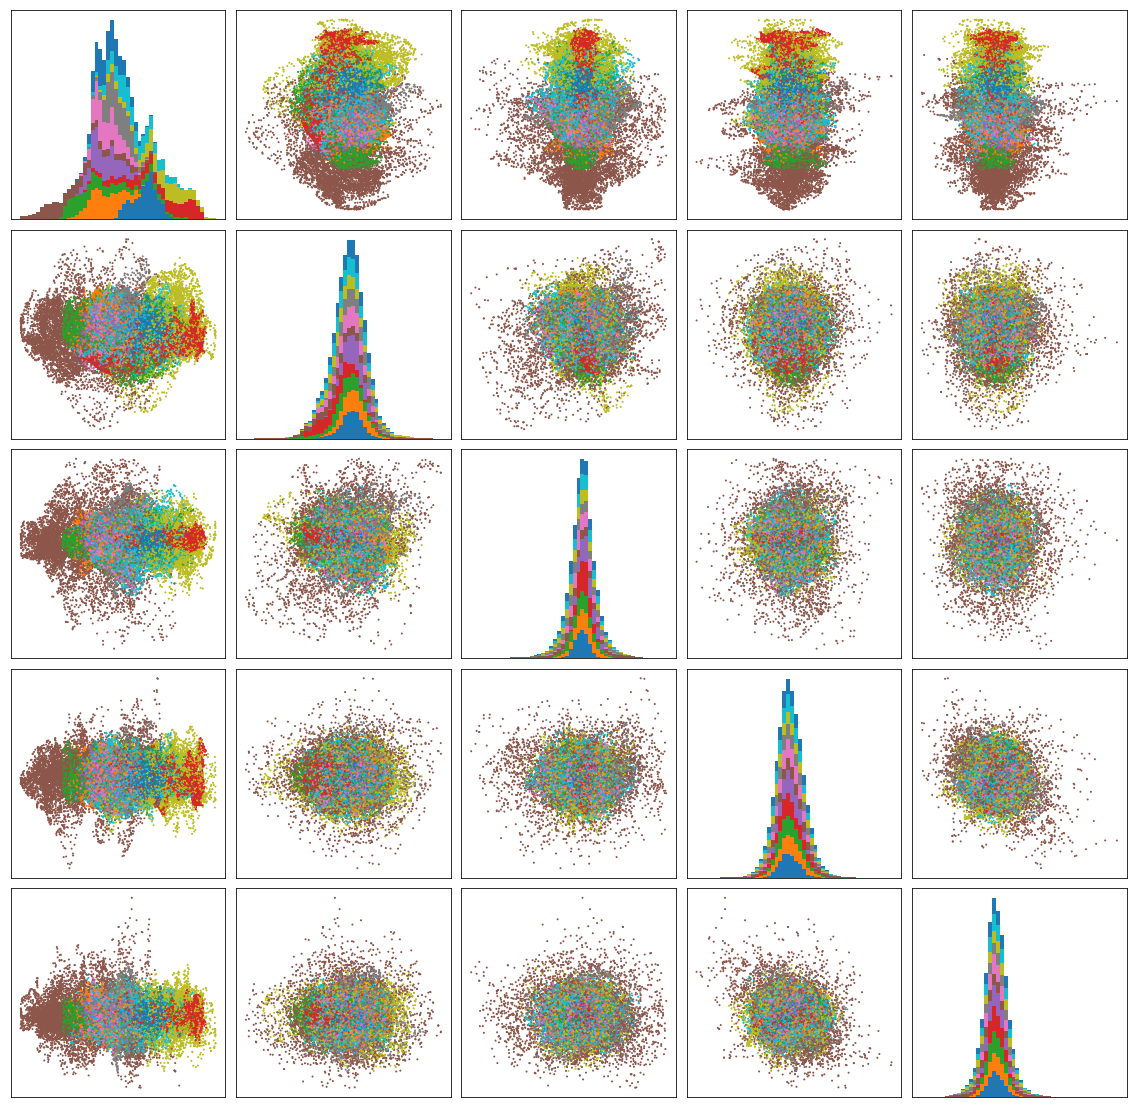

In [9]:
DU.show_splom(X @ Xu[:,:5], labels=Xlab, width=20)

**Observations:**

1. PC1, which accounts for average image intensity, is the best component for classifying the data by source image.
2. There may be some other weak relationships with PC2 and PC3.
3. The data is very scattered, and does not appear to be easy to classify, in general.


### Isomap

We compare the Isomap embeddings of the data when projected into the first $k$ principal components.

Due to slow runtimes for Isomap on large datasets, we limit the number of points to `20,000`.

In [10]:
nsamp = 20000
Xsamp = X[:nsamp]

In [11]:
%cache isomap_grass_pca5 = DU.isomap_embedding(Xsamp @ Xu[:,:5])
%cache isomap_grass_pca10 = DU.isomap_embedding(Xsamp @ Xu[:,:10])
%cache isomap_grass_pca20 = DU.isomap_embedding(Xsamp @ Xu[:,:20])
%cache isomap_grass_pca50 = DU.isomap_embedding(Xsamp @ Xu[:,:50])
%cache isomap_grass_pca100 = DU.isomap_embedding(Xsamp @ Xu[:,:100])
%cache isomap_grass_all = DU.isomap_embedding(Xsamp)

loading cached value for variable 'isomap_grass_pca5'. Time since pickling  4 days, 11:53:05.414279
loading cached value for variable 'isomap_grass_pca10'. Time since pickling  4 days, 11:46:12.676055
loading cached value for variable 'isomap_grass_pca20'. Time since pickling  4 days, 11:40:37.227593
loading cached value for variable 'isomap_grass_pca50'. Time since pickling  4 days, 11:18:43.143334
loading cached value for variable 'isomap_grass_pca100'. Time since pickling  4 days, 11:28:06.151043
loading cached value for variable 'isomap_grass_all'. Time since pickling  4 days, 11:03:16.750258


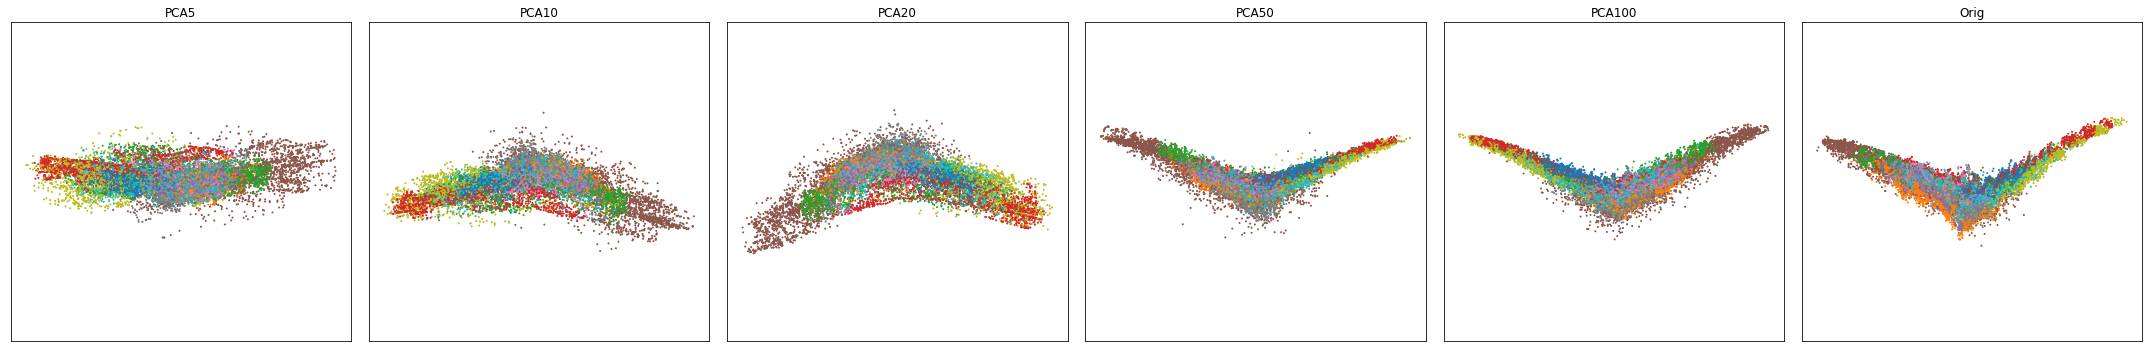

In [12]:
DU.show_embeddings(
    [isomap_grass_pca5, isomap_grass_pca10, isomap_grass_pca20, isomap_grass_pca50, isomap_grass_pca100, isomap_grass_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab[:nsamp]
)

**Observations:**

1. There is little variation across the range of embedding produced.
2. The manifold appears to be dominated by a single dimension which roughly corresponds to PC1.


### Student-T Stochastic Neighbor (t-SNE)



In [15]:
%cache tsne_grass_pca5 = DU.tsne_embedding(X @ Xu[:,:5])
%cache tsne_grass_pca10 = DU.tsne_embedding(X @ Xu[:,:10])
%cache tsne_grass_pca20 = DU.tsne_embedding(X @ Xu[:,:20])
%cache tsne_grass_pca50 = DU.tsne_embedding(X @ Xu[:,:50])
%cache tsne_grass_pca100 = DU.tsne_embedding(X @ Xu[:,:100])
%cache tsne_grass_all = DU.tsne_embedding(X)

loading cached value for variable 'tsne_grass_pca5'. Time since pickling  4 days, 10:23:11.585073
loading cached value for variable 'tsne_grass_pca10'. Time since pickling  4 days, 10:08:35.040833
loading cached value for variable 'tsne_grass_pca20'. Time since pickling  4 days, 9:52:41.444694
loading cached value for variable 'tsne_grass_pca50'. Time since pickling  4 days, 9:33:31.915942
loading cached value for variable 'tsne_grass_pca100'. Time since pickling  4 days, 9:09:23.822047
loading cached value for variable 'tsne_grass_all'. Time since pickling  4 days, 7:10:24.084590


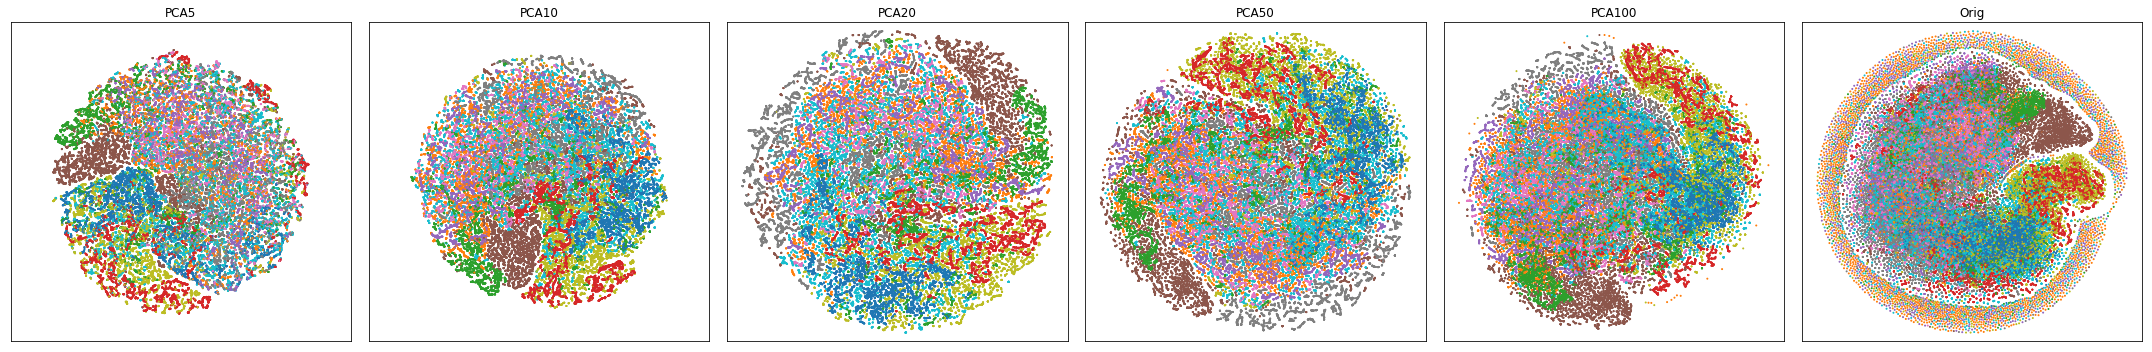

In [16]:
DU.show_embeddings(
    [tsne_grass_pca5, tsne_grass_pca10, tsne_grass_pca20, tsne_grass_pca50, tsne_grass_pca100, tsne_grass_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab
)

**Observations:**

1. t-SNE tends to produce dense (oftentimes circular) representations of the manifold for larger datasets.
2. If we look carefully at the larger white gaps, and imagine unwrapping the structure, we can see that there is an elongated manifold which varies from red (at one end) to brown (at the other).  This is especially evident in the embeddings of PCA50, PCA100, and the original data.
3. t-SNE produces a some fascinating textures in the embedding.  However t-SNE can produce similar textures for random point clouds, so not too much should be made of this.
4. There is arguably little change in the manifold from PCA20-PCA100.
5. The original data embedding is surrounded by a haze (cloud) of outlier points which were not seen in the PCA reduced versions.

### Uniform Manifold Approximation and Projection (UMAP)

Here, we look at same PCA projections of the data using UMAP.

In [17]:
%cache umap_grass_pca5 = DU.umap_embedding(X @ Xu[:,:5], n_neighbors=30)
%cache umap_grass_pca10 = DU.umap_embedding(X @ Xu[:,:10], n_neighbors=30)
%cache umap_grass_pca20 = DU.umap_embedding(X @ Xu[:,:20], n_neighbors=30)
%cache umap_grass_pca50 = DU.umap_embedding(X @ Xu[:,:50], n_neighbors=30)
%cache umap_grass_pca100 = DU.umap_embedding(X @ Xu[:,:100], n_neighbors=30)
%cache umap_grass_all = DU.umap_embedding(X, n_neighbors=30)

loading cached value for variable 'umap_grass_pca5'. Time since pickling  3 days, 23:13:29.906243
loading cached value for variable 'umap_grass_pca10'. Time since pickling  3 days, 23:12:00.849536
loading cached value for variable 'umap_grass_pca20'. Time since pickling  3 days, 23:10:29.571946
loading cached value for variable 'umap_grass_pca50'. Time since pickling  3 days, 23:08:51.827190
loading cached value for variable 'umap_grass_pca100'. Time since pickling  3 days, 23:07:07.162623
loading cached value for variable 'umap_grass_all'. Time since pickling  3 days, 23:04:51.402577


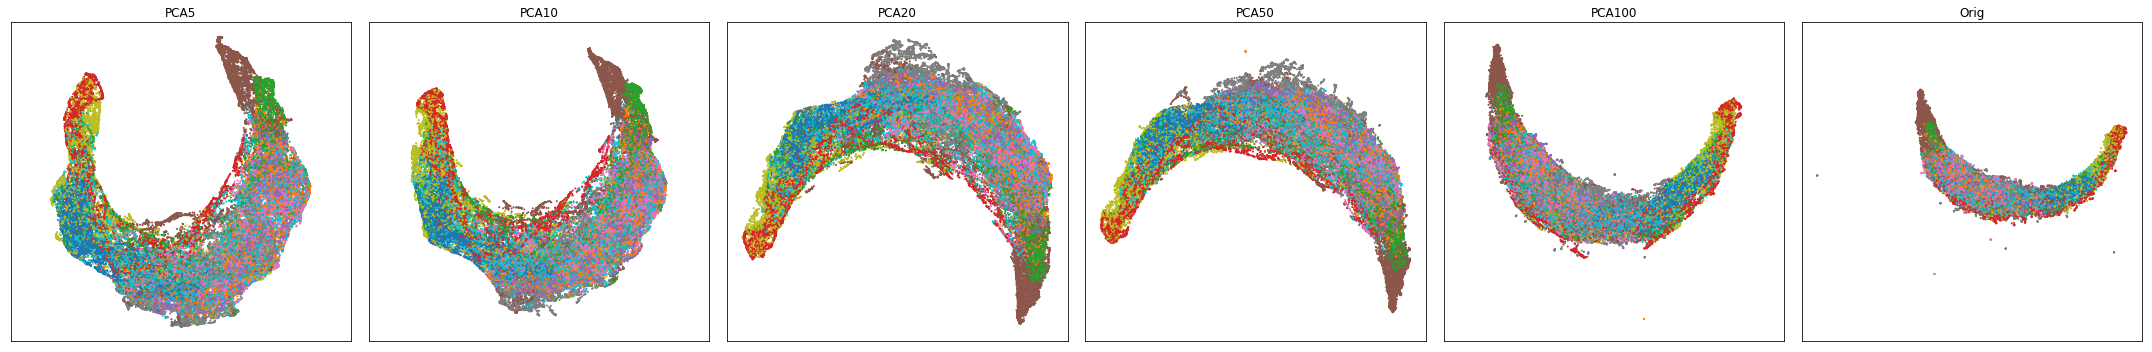

In [18]:
DU.show_embeddings(
    [umap_grass_pca5, umap_grass_pca10, umap_grass_pca20, umap_grass_pca50, umap_grass_pca100, umap_grass_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab
)

**Observations:**

1. UMAP reveals a consistently "U" shaped manifold for the grass data.
2. The embeddings of PCA100 and the original data appear smaller, but this is merely an artifact scaling to include outlier points where are not present in the lower dimensional embeddings.
3. As with other manifold visualizations, the manifold is elongated in one dimension with a "red" tip and a "brown" tip.
4. There are regions of color concentration in every representation, but these are not well defined enough to classify the source image.

UMAP and Isomap produced the most useful and consistent embeddings of the manifold.


## Conclusion: Manifold lies in 10-20 dimensional subspace

1. Grass data lies on an elongated manifold which is only able to hint about the identity of the source image.
2. There is no apparent improvement in the detail of the manifold beyond 20 PCA dimensions, and even this is only a scant improvement over 10 PCA dimensions.
3. It should be noted that although 10-20 dimensions accounts for most of the shape of the manifold as seen in an embedding, many more dimensions (200+) are required to obtain a grass texture recognizable to a human.

Based on this, we argue that the grass texture manifold lies (roughly) within a 10-20 dimensional subspace, and the manifold has a single, dominant direction which varies with average image intensity.


In [19]:
%cache